In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

<ipython-input-63-994af0d1c5b5>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [64]:
warnings.filterwarnings("ignore")

In [65]:
# Reuse functio from previou template.
# This function read data from excel and csv files to dataframe.
# Input Arguments file: File name with path (Eg: 'D:/data/dataread.csv'), f_type: File Type (Eg: 'csv',default csv)
def file_todataframe(file,f_type):
    if f_type == 'csv':  
        return pd.read_csv(file)
    elif f_type == 'excel': 
        return pd.read_excel(file)
    elif f_type == 'json': 
        return pd.read_json(file)
    
# This function display shape, data type, data near head and tail of given data fram.
# Input Arguments df: dataframe, n: No f data points to display
def df_details(d_f,n):
    print('Data Types of Column: \n',d_f.dtypes)
    print('\n Size of Datarame: ',d_f.shape)
    print('\n Top and bottom ',n,' rows: \n')
    display(d_f.head(n).append(d_f.tail(n)))
    
# This function give deatials for missing values in data
# Input Arguments df: dataframe
def miss_ch(d_f):
    print('Available data with no nulls: ', d_f.dropna().shape[0])
    display('Deatils of Null values column wise',d_f.isnull().sum())
    

# Function for Canging column type
# Input Arguments df: dataframe, col_int: Columns of intrest (Eg: ['Sale','Customer'],['all'] default 'all'), 
# dtyp: New data types of coloumn default int
def col_dtype(d_f,col_int,dtyp = int):
    d_f = deep_copy(d_f)
    av_fun = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','int','float','str','category']
    col_nam = d_f.columns
    #Checking Parameter Column names
    if not all(i in col_nam for i in col_int):
        print("Invalid column name")
        return 
    #Checking Parameter available function
    if not dtyp in av_fun:
        print("Invalid data type")
        return
    
    d_f[col_int] = d_f[col_int].astype(dtyp,errors='ignore')
    return d_f

### Funtion to Convert Time series to Supervised Learning Problem

In [66]:
## Function to return SL problem by taking a Time series data
# lag define the the how many and how much shifts to be included, for lag = [1,3] : will include one t-1 and t-3 data columns
def ts2sl(d_f,col, lag=[1,2]):
    d_f = d_f.copy(deep=True)
    x = 1
    for i in lag:
        xst = 'x'+ str(x)
        d_f[xst] = d_f[col].shift(i)
        x = x+1
    xst = 'x'+ str(x)   
    d_f.rename(columns = {col: 'y'}, inplace = True)
    return d_f

### Funtion to Fill Missing Values for Time Series data

In [67]:
# This function fill missing values
def fill_miss(d_f,col_int = 'all',metd = None):
    col_nam = d_f.columns
    av_method = ['bfill', 'pad', 'ffill', 'linear','mean']
    
    if not col_int in col_nam:
        print("Invalid column name")
        return d_f
    if metd == None:
        return d_f
    elif (metd == 'mean'):
        d_f[col_int] = d_f[col_int].fillna(value=d_f[col_int].mean()) 
        return d_f
    elif metd == 'linear':
        d_f[col_int] = d_f[col_int].interpolate(method = 'linear') 
        return  d_f
    elif  metd in av_method:
        d_f[col_int] = d_f[col_int].fillna(method = metd)
        return d_f
    else:
        print("Invalid fill type")
        return d_f

## Working on Airline Passenger Dataset

In [68]:
# Reading File
df =  file_todataframe('airline-passengers.csv','csv')

In [69]:
#Data Details
df_details(df,3)

Data Types of Column: 
 Month          object
Passengers    float64
dtype: object

 Size of Datarame:  (144, 2)

 Top and bottom  3  rows: 



,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [70]:
# Converting Months column in Datetime
df['Month'] = pd.to_datetime(df['Month'], format="%Y-%m")
df.head(5)

,Month,Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,NaN
4,1949-05-01,121.0


## Problem 2 (Missing Value)

In [72]:
#Checking if any missing values
miss_ch(df)

Available data with no nulls:  143


'Deatils of Null values column wise'

Month         0
Passengers    1
dtype: int64

#### There is one Missing value which i put intensionaly, Forward fill to fill that value.

In [73]:
df = fill_miss(df,col_int = 'Passengers',metd = 'ffill')

In [74]:
df.head(6)

,Month,Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,132.0
4,1949-05-01,121.0
5,1949-06-01,135.0


### Problem 1 (Converting to Supervised Learning Problem)

In [75]:
# Setting Date column as index
df=df.set_index("Month")
df.loc['1949-01-01']

Passengers    112.0
Name: 1949-01-01 00:00:00, dtype: float64

In [76]:
df.head(5)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,132.0
1949-05-01,121.0


In [78]:
## Calling function from above to conveert this into SL problem
sl = ts2sl(df,'Passengers', lag=[1,3,5])
sl.head(10)

,y,x1,x2,x3
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,112.0,NaN,NaN
1949-03-01,132.0,118.0,NaN,NaN
1949-04-01,132.0,132.0,112.0,NaN
1949-05-01,121.0,132.0,118.0,NaN
1949-06-01,135.0,121.0,132.0,112.0
1949-07-01,148.0,135.0,132.0,118.0
1949-08-01,148.0,148.0,121.0,132.0
1949-09-01,136.0,148.0,135.0,132.0


### Problem 3: Plot the time series

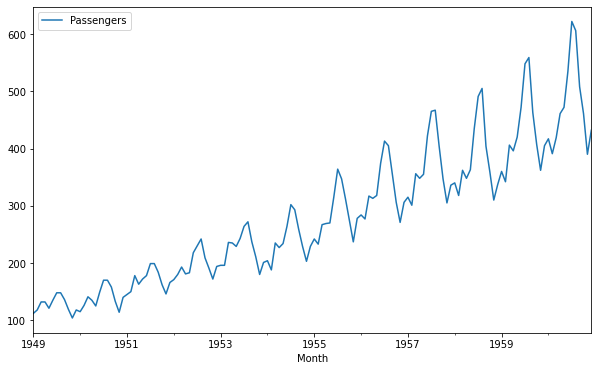

In [80]:
df.plot(figsize=(10,6))
plt.show()

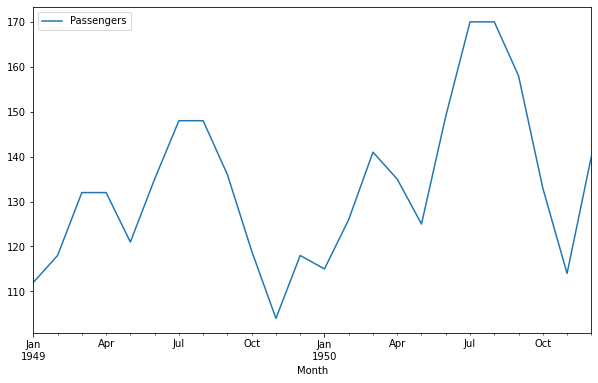

In [82]:
# Zoomed version 
df.iloc[0:24].plot(figsize=(10,6))
plt.show()

### Observation
### Trend:
As from the above signal we chane see their is a clear trend as signal increasing over time. An upward trend in data
### Seasonality:
Also from graph we can the the seasonal pattern in the signal, monthly data repeats the same poattern after each year that is peaks and troughs in same month every year.
### Cyclic
No there is no  cyclical component in the given time series.


### Problem 4: Time Series Decomposition

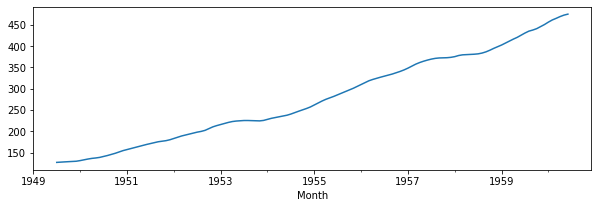

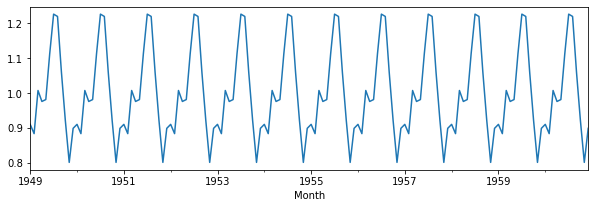

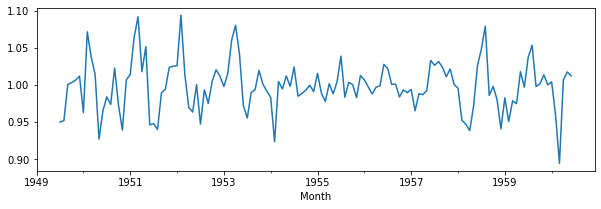

In [99]:
## Multiplicative Decomposition
## As we can see in the last graph that amplitude of seasonal component increase with rise in trend
result = seasonal_decompose(df, model='multiplicative')
result.trend.plot(figsize=(10,3))
plt.show()
result.seasonal.plot(figsize=(10,3))
plt.show()
result.resid.plot(figsize=(10,3))
plt.show()

#### As interpreted in the last question in thish we can see all the components of the given time series signal

## Problem 5 & 6: Differencing Required

In [100]:
## Checking for stationarity
X=df.values
result=adfuller(X)
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print(' Citical Values:')
for key , value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.820955
p-value : 0.991967
 Citical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### As from the results of above Dickey-Fuller test the signal is non statinary at level so we have to take differencing. So taking first difference

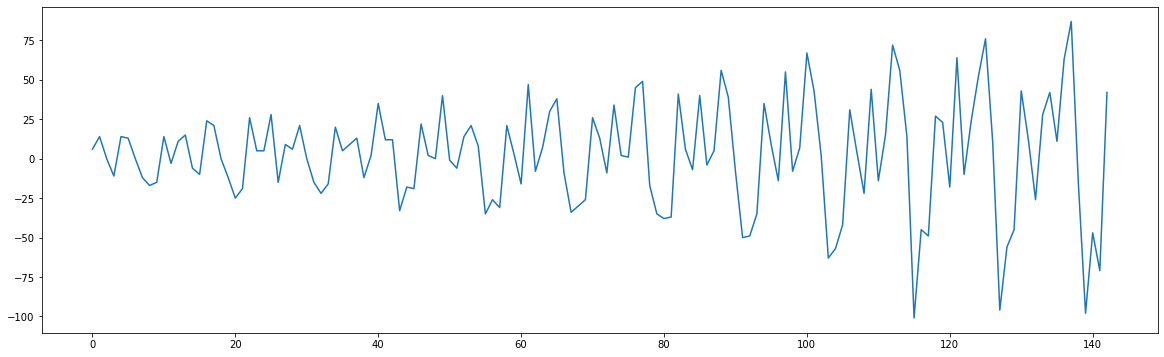

In [101]:
diff=list()
X=df.values
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)

plt.figure(figsize=(20,6))
plt.plot(diff)
plt.show()

In [102]:
result=adfuller(diff)
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print(' Citical Values:')
for key , value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.825302
p-value : 0.054749
 Citical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### As from the results of above Dickey-Fuller test the signal is  stationary at first difference with 10% but nonstationary at  5% so we have to take another differencing. So taking second difference

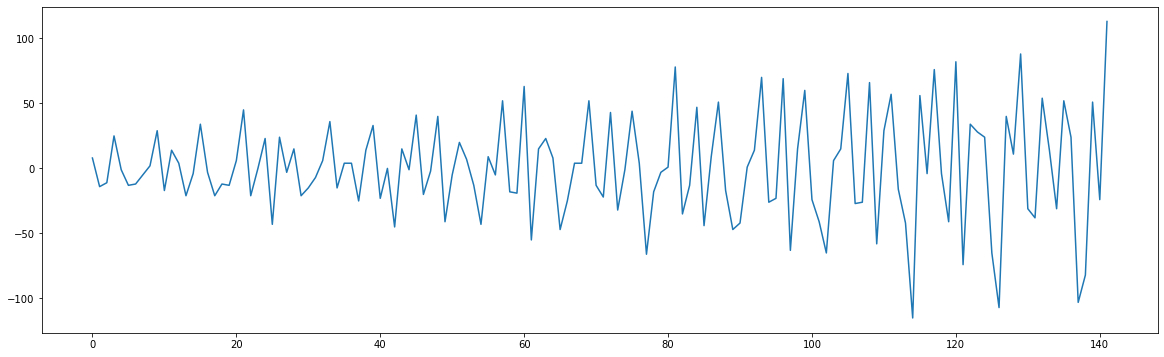

In [103]:
diff2=list()
for i in range(1, len(diff)):
    value = diff[i] - diff[i - 1]
    diff2.append(value)

plt.figure(figsize=(20,6))
plt.plot(diff2)
plt.show()

In [104]:
result=adfuller(diff2)
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print(' Citical Values:')
for key , value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.350939
p-value : 0.000000
 Citical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


### Signal is statinary at second differennce

## Problem 7: Generate forecasts with persistence model

In [108]:
# Create lagged dataset
values = pd.DataFrame(df.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
def model_persistence(x):
    return x
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

       t    t+1
0    NaN  112.0
1  112.0  118.0
2  118.0  132.0
3  132.0  132.0
4  132.0  121.0
Test RMSE: 65.913


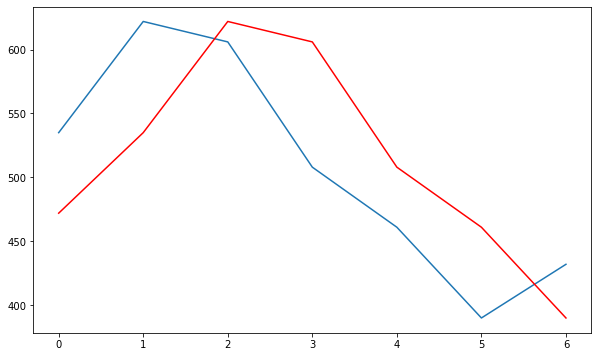

In [109]:
# plot predictions vs expected
plt.figure(figsize=(10,6))
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

## Problem 8: Generate forecasts with AR

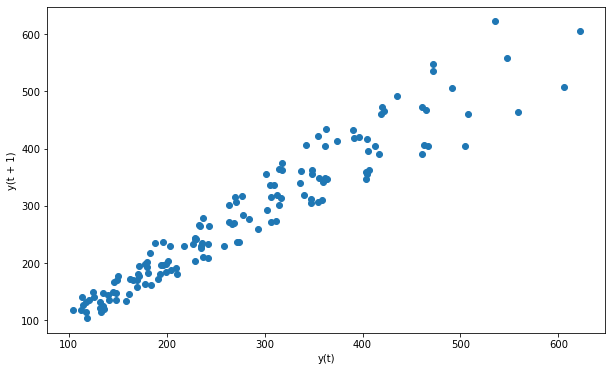

In [54]:
## Checking for auto corelation
from pandas.plotting import lag_plot
plt.figure(figsize=(10,6))
lag_plot(df)
plt.show()

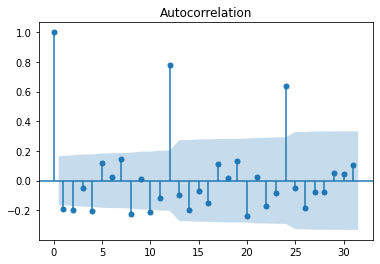

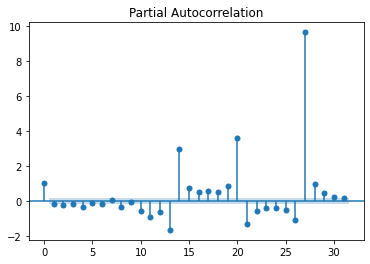

In [133]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diff2, lags=31)
pyplot.show()
plot_pacf(diff2, lags=31)
pyplot.show()

In [111]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
X = df.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Lag: 13
Coefficients: [ 4.73003077  0.80806539 -0.14286477  0.05829601 -0.02439778  0.07980064
 -0.12114057  0.08365621 -0.09901091  0.14509308 -0.16491623  0.17869477
  0.87417111 -0.65826279]
predicted=518.416828, expected=535.000000
predicted=602.522374, expected=622.000000
predicted=610.740185, expected=606.000000
predicted=516.891041, expected=508.000000
predicted=445.205971, expected=461.000000
predicted=401.684838, expected=390.000000
predicted=446.643085, expected=432.000000
Test RMSE: 13.920


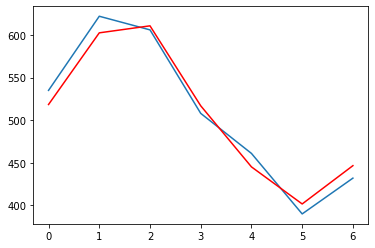

In [112]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Problem 9: Generate forecasts with MA

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  134
Model:                     ARMA(0, 3)   Log Likelihood                -644.020
Method:                       css-mle   S.D. of innovations             28.968
Date:                Sat, 08 May 2021   AIC                           1298.039
Time:                        23:43:14   BIC                           1312.528
Sample:                             0   HQIC                          1303.927
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0139      0.064      0.218      0.827      -0.111       0.139
ma.L1.y       -0.6409      0.106     -6.045      0.000      -0.849      -0.433
ma.L2.y       -0.7325      0.123     -5.969      0.0

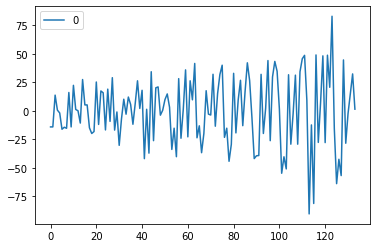

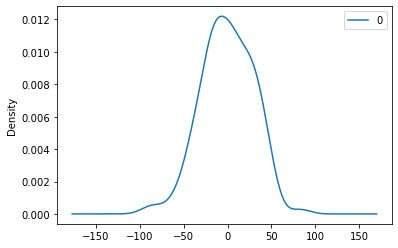

                0
count  134.000000
mean    -0.156508
std     29.322382
min    -90.359887
25%    -18.960575
50%      0.646839
75%     21.012746
max     83.115146
predicted=-19.092883, expected=52.000000
predicted=11.008062, expected=24.000000
predicted=0.596833, expected=-103.000000
predicted=0.013866, expected=-82.000000
predicted=0.013866, expected=51.000000
predicted=0.013866, expected=-24.000000
predicted=0.013866, expected=113.000000
Test RMSE: 74.281


In [127]:
#Using Arima Model for MA with AR term 0
from statsmodels.tsa.arima_model import ARIMA
X = diff2
train, test = X[1:len(X)-7], X[len(X)-7:]
model = ARIMA(train, order=(0,0,3))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

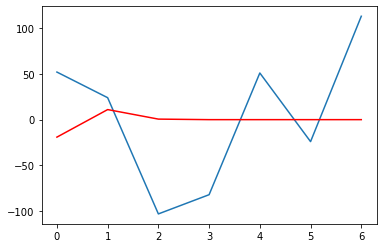

In [128]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Problem 10: Generate forecasts with ARIMA

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  133
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -694.514
Method:                       css-mle   S.D. of innovations             44.696
Date:                Sat, 08 May 2021   AIC                           1399.029
Time:                        23:45:27   BIC                           1413.481
Sample:                             1   HQIC                          1404.902
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0358      1.512      0.024      0.981      -2.927       2.999
ar.L1.D.y     -0.8037      0.085     -9.470      0.000      -0.970      -0.637
ar.L2.D.y     -0.5734      0.098     -5.859      0.0

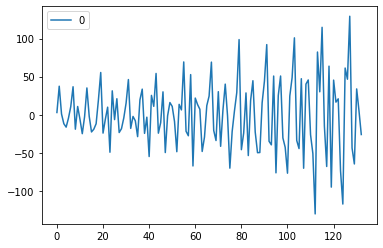

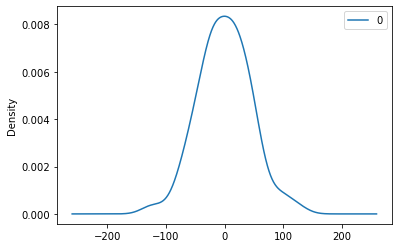

                0
count  133.000000
mean     0.171998
std     44.890765
min   -130.085165
25%    -26.226961
50%     -1.590362
75%     30.039595
max    129.251799
predicted=40.255743, expected=52.000000
predicted=1.779924, expected=24.000000
predicted=-15.158750, expected=-103.000000
predicted=2.967046, expected=-82.000000
predicted=6.034195, expected=51.000000
predicted=-3.337895, expected=-24.000000
predicted=-1.296167, expected=113.000000
Test RMSE: 66.633


In [131]:
#Using Arima Model for MA with AR term 0
from statsmodels.tsa.arima_model import ARIMA
X = diff2
train, test = X[1:len(X)-7], X[len(X)-7:]
model = ARIMA(train, order=(3,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

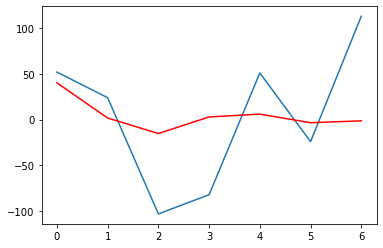

In [132]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Problem 11: Comparision

### AR performed best as compared to the baseline and the other MA and ARIMA model